<center>
   Go back to the <a href="https://github.com/kadrlica/skymap/tree/master/examples/README.md">Index</a>
</center>

# Tutorial 3: Skymap and HEALPix

In this tutorial we introduce the interface between `cartosky.Skymap` and [HEALPix](http://healpix.sf.net) ([Gorski et al. 2005](https://arxiv.org/abs/astro-ph/0409513)). The ability to accurately draw HEALPix maps with minimal overhead is one of the most powerful (and useful) feature of `cartosky`.


In [1]:
# Basic notebook imports
%matplotlib inline

import matplotlib
import pylab as plt
import numpy as np
import healpy as hp

We start by importing several classes from the skymap module and setting a few constants that we will use in this example. By this point, these modules and classes should be familiar.

In [2]:
import cartosky
from cartosky import Skymap,McBrydeSkymap,OrthoSkymap
from cartosky import SurveySkymap,SurveyMcBryde,SurveyOrtho
from cartosky import DESSkymap

SKYMAPS = [Skymap,McBrydeSkymap,OrthoSkymap]
SURVEYS = [SurveySkymap,SurveyMcBryde,SurveyOrtho]

NSIDE = 8

We start off by creating and drawing a simple, low-resolution HEALPix map in ring format.

/usr/local/anaconda2/envs/carto/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/usr/local/anaconda2/envs/carto/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/usr/local/anaconda2/envs/carto/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


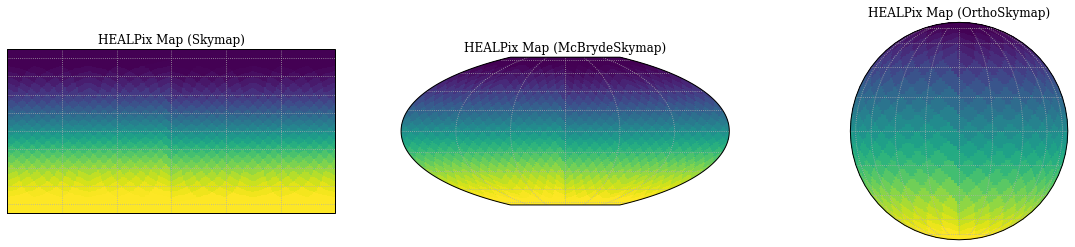

In [3]:
hpxmap = np.arange(hp.nside2npix(NSIDE))
fig,axes = plt.subplots(1,3,figsize=(20,4))
for i,cls in enumerate(SKYMAPS):
    plt.sca(axes[i])
    m = cls()
    m.draw_hpxmap(hpxmap,xsize=200)
    plt.title('HEALPix Map (%s)'%cls.__name__)

This is nothing special compared to what you can do with [`healpy.visfunc`](https://healpy.readthedocs.io/en/latest/healpy_visu.html), but remember that `cartosky` gives you access to the underlying power of `PROJ`.

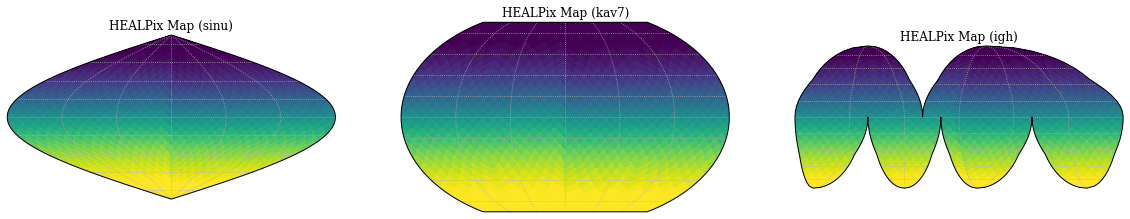

In [4]:
hpxmap = np.arange(hp.nside2npix(NSIDE))
fig,axes = plt.subplots(1,3,figsize=(20,4))
for i,proj in enumerate(['sinu','kav7','igh']):
    plt.sca(axes[i])
    smap = Skymap(projection=proj,lon_0=0)
    im,lon,lat,values = smap.draw_hpxmap(hpxmap,xsize=200)
    plt.title('HEALPix Map (%s)'%proj)

The `draw_hpxmap` function returns the image, longitude and latitude of each pixel, and the values of each pixel. You can take that output and draw it yourself if you like.

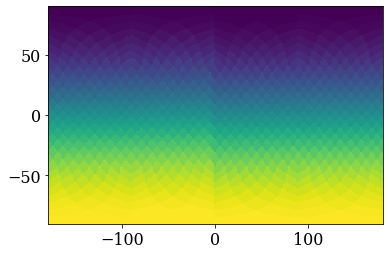

In [5]:
plt.figure()
plt.pcolormesh(lon,lat,values)

The `draw_hpxmap` function can also take a partial HEALPix map where the pixels and values are specified explicitly.

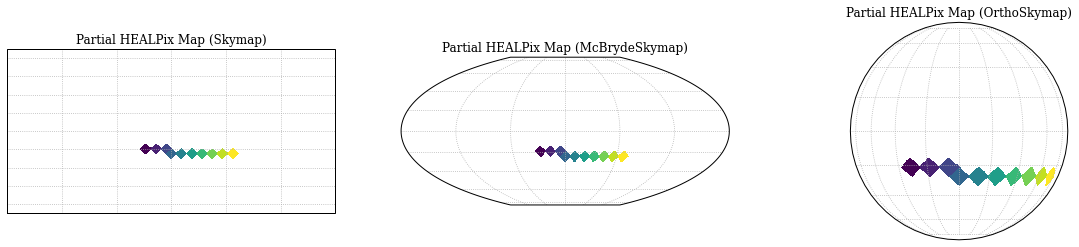

In [6]:
pix = hpxmap = np.arange(525,535)
fig,axes = plt.subplots(1,3,figsize=(20,4))
for i,cls in enumerate(SKYMAPS):
    plt.sca(axes[i])
    m = cls()
    m.draw_hpxmap(hpxmap,pix,NSIDE,xsize=200)
    plt.title('Partial HEALPix Map (%s)'%cls.__name__)

Notice that in the above maps all pixels that are not explicitly specified are masked by `draw_hpxmap`. The same behavior can be accomplished by setting HEALPix values to `np.NaN`, `hp.UNSEEN` or by using the `numpy.MaskedArray` module.

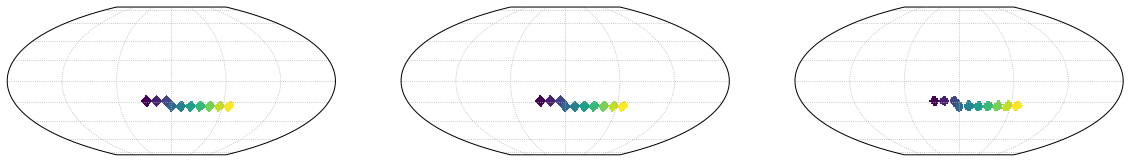

In [7]:
pix = np.arange(525,535)

fig,axes = plt.subplots(1,3,figsize=(20,4))
plt.sca(axes[0])
smap = McBrydeSkymap()
hpxmap = hp.UNSEEN * np.ones(hp.nside2npix(NSIDE))
hpxmap[pix] = pix
smap.draw_hpxmap(hpxmap,xsize=400)

plt.sca(axes[1])
smap = McBrydeSkymap()
hpxmap = np.nan * np.ones(hp.nside2npix(NSIDE))
hpxmap[pix] = pix
smap.draw_hpxmap(hpxmap,xsize=400)

plt.sca(axes[2])
smap = McBrydeSkymap()
hpxmap = np.arange(hp.nside2npix(NSIDE))
hpxmap = np.ma.array(hpxmap, mask=~np.in1d(hpxmap,pix))
out = smap.draw_hpxmap(hpxmap,xsize=200)

We have also implemented a HEALPix analog to the [`matplotlib.hexbin`](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.axes.Axes.hexbin.html) function called `hpxbin` (this function returns the healpix map in addition to image and associated pixel values).

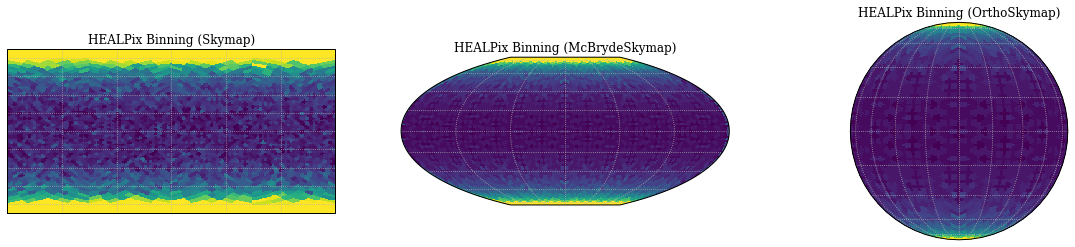

In [8]:
# These are random, non-uniform points
size = int(1e5)
lon = np.random.uniform(0,360,size=size)
lat = np.random.uniform(-90,90,size=size)

fig,axes = plt.subplots(1,3,figsize=(20,4))
for i,cls in enumerate(SKYMAPS):
    plt.sca(axes[i])
    smap = cls()                                                  
    hpxmap,(im,lon,lat,values) = smap.draw_hpxbin(lon,lat,nside=16,xsize=200)
    plt.title('HEALPix Binning (%s)'%cls.__name__)

Because `skymap` can draw partial HEALPix maps with explicit pixel labeling, it is possible to draw small regions of the sky much more efficiently the `healpy`. The true power comes in the ability to plot ultra-high resolution HEALPix maps (nside > 1e5). This would take an enormous amount of memory if you needed to create the entire map. In the plots below notice the change in the size of the axes ranges.

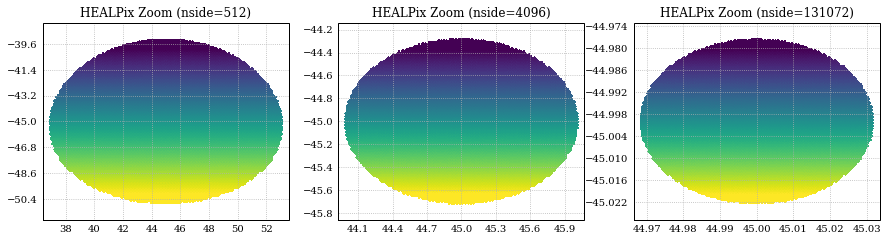

In [9]:
import cartosky.healpix

ra,dec = 45,-45
fig,axes = plt.subplots(1,3,figsize=(15,4))

for i,nside in enumerate([512,4096,4096*2**5]):
    radius = np.degrees(50*hp.nside2resol(nside))
    pixels = cartosky.healpix.ang2disc(nside,ra,dec,radius)
    values = pixels
    
    plt.sca(axes[i])

    # Use the Plate-Carree projection, then zoom.
    m = Skymap(projection='cyl')
    llcrnrlon,urcrnrlon=ra+1.5*radius,ra-1.5*radius,
    llcrnrlat,urcrnrlat=dec-1.2*radius,dec+1.2*radius
    m.ax.set_extent([llcrnrlon,urcrnrlon,llcrnrlat,urcrnrlat])

    m.draw_hpxmap(values,pixels,nside=nside,xsize=400)
    m.grid.xlabels_bottom = True
    m.grid.ylabels_left = True

    plt.title('HEALPix Zoom (nside=%i)'%nside)

<center>
   Go back to the <a href="https://github.com/kadrlica/skymap/tree/master/examples/README.md">Index</a>
</center>